**Install required libraries**

In [ ]:
!pip install pywaffle
!pip install geopy
!pip install bs4
!pip install lxml

**Import required libraries**

In [2]:
import matplotlib.pyplot as plt
from pywaffle import Waffle # for visualization
import numpy as np
import pandas as pd
from geopy.geocoders import Nominatim
import requests
from bs4 import BeautifulSoup as bs
import lxml
from pandas.io.json import json_normalize

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library
print('Libraries imported.')

Libraries imported.


**Data : 1. Data Wrangling**   
*1.1 First Data : Congressional Districts Los Angeles County - By Zip Code*

*Source:<a> http://www.laalmanac.com/government/gu02a.php</a>*    
<p>We selected this data because of many zip code areas are split among two or more communities, being similar to the Borough organization to NYC or Toronto (previous exercise). </p>

In [3]:
# Data URL
url = 'http://www.laalmanac.com/government/gu02a.php'

# Initiate HTTP request and save response into res variable
res = requests.get(url).text

# Format response as XML
soup = bs(res,'lxml')

# save only first table in the response into variabe table
table = soup.find_all('table')[0] 

# save this table into temp data frame
df1 = pd.read_html(str(table))[0]


In [4]:
df1.head()

,Zip Code – City/Community,District(s)
0,"90001 - Los Angeles (South Los Angeles), Flore...","40, 43, 44"
1,90002 - Los Angeles (Watts),"43, 44"
2,90003 - Los Angeles (South Los Angeles/Broadwa...,"37, 40, 43"
3,"90004 - Los Angeles (Rampart Village, Virgil V...","28, 33, 34"
4,90005 - Los Angeles (Wilshire Center),"33, 34, 37"


*We selected only Los Angeles, and it's communities or neighborhoods.*  

**Data : 2. Data Cleaning**  
*2.1 First Data : Congressional Districts Los Angeles County - By Zip Code*

In [5]:
df1= df1[df1['Zip Code – City/Community'].str.contains('Los Angeles')]
df1.head()

,Zip Code – City/Community,District(s)
0,"90001 - Los Angeles (South Los Angeles), Flore...","40, 43, 44"
1,90002 - Los Angeles (Watts),"43, 44"
2,90003 - Los Angeles (South Los Angeles/Broadwa...,"37, 40, 43"
3,"90004 - Los Angeles (Rampart Village, Virgil V...","28, 33, 34"
4,90005 - Los Angeles (Wilshire Center),"33, 34, 37"


In [6]:
# Removing unwanted columns

df1.drop(['District(s)'],axis=1, inplace=True)
df1.head()

,Zip Code – City/Community
0,"90001 - Los Angeles (South Los Angeles), Flore..."
1,90002 - Los Angeles (Watts)
2,90003 - Los Angeles (South Los Angeles/Broadwa...
3,"90004 - Los Angeles (Rampart Village, Virgil V..."
4,90005 - Los Angeles (Wilshire Center)


In [7]:
# Splitting 'Zip Code – City/Community' column to obtain two columns, one for Zip Code and another for City/Community, 
# this last one requires more splitting(more steps below). Then renaming the columns.  

df1= df1['Zip Code – City/Community'].str.split("-", n=1, expand=True)
df1.columns = ["ZIP Code", "City/Community"] #renaming columns, but the .rename is not working
df1.head()


,ZIP Code,City/Community
0,90001,"Los Angeles (South Los Angeles), Florence-Graham"
1,90002,Los Angeles (Watts)
2,90003,Los Angeles (South Los Angeles/Broadway Manch...
3,90004,"Los Angeles (Rampart Village, Virgil Village,..."
4,90005,Los Angeles (Wilshire Center)


In [8]:
# With the next splitting process, we cannot keep the ZIP Code column, but we require it, and we'll recover it by inner join, 
# in the following steps. Thus, creating a new column index1 will be the matching criterion with the next data frame df2.

df1['index1'] = df1.index
df1.head()

,ZIP Code,City/Community,index1
0,90001,"Los Angeles (South Los Angeles), Florence-Graham",0
1,90002,Los Angeles (Watts),1
2,90003,Los Angeles (South Los Angeles/Broadway Manch...,2
3,90004,"Los Angeles (Rampart Village, Virgil Village,...",3
4,90005,Los Angeles (Wilshire Center),4


In [9]:
# Splitting 'City/Community' column to separate Los Angeles city from it's communities. Then renaming the columns

df2=df1["City/Community"].str.split("(", n=1, expand=True)  
df2.columns = ["City","Community"] 
df2.head()

,City,Community
0,Los Angeles,"South Los Angeles), Florence-Graham"
1,Los Angeles,Watts)
2,Los Angeles,South Los Angeles/Broadway Manchester)
3,Los Angeles,"Rampart Village, Virgil Village, Wilshire Center)"
4,Los Angeles,Wilshire Center)


In [10]:
# To remove unwanted characters as the parenthesis )

df2['Community']=df2['Community'].str.replace(r")"," ")
df2.head()

,City,Community
0,Los Angeles,"South Los Angeles , Florence-Graham"
1,Los Angeles,Watts
2,Los Angeles,South Los Angeles/Broadway Manchester
3,Los Angeles,"Rampart Village, Virgil Village, Wilshire Center"
4,Los Angeles,Wilshire Center


In [11]:
# Creating a new column 'index2', that have common values with the previous data frame df1['index1'], to apply the inner join.

df2['index2'] = df2.index
df2.head()


,City,Community,index2
0,Los Angeles,"South Los Angeles , Florence-Graham",0
1,Los Angeles,Watts,1
2,Los Angeles,South Los Angeles/Broadway Manchester,2
3,Los Angeles,"Rampart Village, Virgil Village, Wilshire Center",3
4,Los Angeles,Wilshire Center,4


In [12]:
# Applying inner join for the two data frames: df with df2, to consolidate into one data frame the ZIP Code, City, and Community.

df3=df1.join(df2.set_index('index2'), on='index1', how='inner')
df3.head()


,ZIP Code,City/Community,index1,City,Community
0,90001,"Los Angeles (South Los Angeles), Florence-Graham",0,Los Angeles,"South Los Angeles , Florence-Graham"
1,90002,Los Angeles (Watts),1,Los Angeles,Watts
2,90003,Los Angeles (South Los Angeles/Broadway Manch...,2,Los Angeles,South Los Angeles/Broadway Manchester
3,90004,"Los Angeles (Rampart Village, Virgil Village,...",3,Los Angeles,"Rampart Village, Virgil Village, Wilshire Center"
4,90005,Los Angeles (Wilshire Center),4,Los Angeles,Wilshire Center


In [13]:
# Dropping unwanted column "index1"

df3.drop(["City/Community","index1"], axis=1, inplace=True)
df3.head()

,ZIP Code,City,Community
0,90001,Los Angeles,"South Los Angeles , Florence-Graham"
1,90002,Los Angeles,Watts
2,90003,Los Angeles,South Los Angeles/Broadway Manchester
3,90004,Los Angeles,"Rampart Village, Virgil Village, Wilshire Center"
4,90005,Los Angeles,Wilshire Center


**Methodology : 3. Exploratory Data Analysis**   
*3.1 First Data : Congressional Districts Los Angeles County - By Zip Code*

In [14]:
# Checking the data frame structure and data type
df3.shape

(107, 3)

In [15]:
df3.isnull().sum(axis = 0)

ZIP Code     0
City         0
Community    2
dtype: int64

In [16]:
df3.dtypes

ZIP Code     object
City         object
Community    object
dtype: object

In [17]:
# Converting data type of ZIP Code column to avoid future error on the join method. Then, verify that the data type changed.

df3['ZIP Code']=df3['ZIP Code'].astype(int)
df3.dtypes

ZIP Code      int64
City         object
Community    object
dtype: object

In [18]:
print('Above the ready First dataset(df3) with the structure format wanted -->\
Community: South Los Angeles , Florence-Graham. Several communities by each zip code')

Above the ready First dataset(df3) with the structure format wanted -->Community: South Los Angeles , Florence-Graham. Several communities by each zip code


**Data : 1. Data Wrangling**   
*1.2 Second Data : Los Angeles Zip Codes and Latitude/Longitude by each neighborhood in Los Angeles county*  
*Source: https://data.lacounty.gov/GIS-Data/ZIP-Codes-and-Postal-Cities/wft9-k7e3 --> Direct dowloaded from the web page to Excel or use download URL https://data.lacounty.gov/api/views/c3xr-3jw2/rows.csv*   
<p>Getting the latitude and the longitude coordinates of each neighborhood </p>

In [19]:
df4 = pd.read_csv('https://data.lacounty.gov/api/views/c3xr-3jw2/rows.csv')

In [20]:
df4.head()

,ZIP Code,Postal City 1,Postal City 2,Postal City 3,Not Acceptable 1,Not Acceptable 2,Not Acceptable 3,Location
0,90713,Lakewood,NaN,NaN,NaN,NaN,NaN,"90713(33.84871142900005, -118.11357922799999)"
1,91306,Winnetka,NaN,NaN,NaN,NaN,NaN,"91306(34.208404020000046, -118.57593995299999)"
2,90002,Los Angeles,NaN,NaN,NaN,NaN,NaN,"90002(33.94895070600006, -118.24697958699994)"
3,90506,Torrance,NaN,NaN,NaN,NaN,NaN,"90506(33.88535286100006, -118.32659746799999)"
4,90069,West Hollywood,Los Angeles,NaN,NaN,NaN,NaN,"90069(34.08940300900008, -118.37978902499998)"


**Data : 2. Data Cleaning**   
*2.2 Second Data : Los Angeles Zip Codes and Latitude/Longitude by each neighborhood in Los Angeles county*

In [21]:
# Dropping unwanted columns

df4.drop(['Postal City 2','Postal City 3','Not Acceptable 1','Not Acceptable 2','Not Acceptable 3'], axis=1, inplace=True)
df4=df4.rename(columns={"Postal City 1": "Neighborhoods"})
df4.head()

,ZIP Code,Neighborhoods,Location
0,90713,Lakewood,"90713(33.84871142900005, -118.11357922799999)"
1,91306,Winnetka,"91306(34.208404020000046, -118.57593995299999)"
2,90002,Los Angeles,"90002(33.94895070600006, -118.24697958699994)"
3,90506,Torrance,"90506(33.88535286100006, -118.32659746799999)"
4,90069,West Hollywood,"90069(34.08940300900008, -118.37978902499998)"


In [22]:
# Location column mixed information, and it contains the geographic coordinates and zip codes in the same row.
# Thus, it should be fixed by splitting the values and then erasing the duplicate zip codes.

#https://cmdlinetips.com/2018/11/how-to-split-a-text-column-in-pandas/

df4[['ZIP_Code_dupplicate','Latitude2']] =df4.Location.str.split('(',expand=True, )
df4[['Latitude','Longitude']] =df4.Latitude2.str.split(expand=True, )
df4.head()

,ZIP Code,Neighborhoods,Location,ZIP_Code_dupplicate,Latitude2,Latitude,Longitude
0,90713,Lakewood,"90713(33.84871142900005, -118.11357922799999)",90713,"33.84871142900005, -118.11357922799999)","33.84871142900005,",-118.11357922799999)
1,91306,Winnetka,"91306(34.208404020000046, -118.57593995299999)",91306,"34.208404020000046, -118.57593995299999)","34.208404020000046,",-118.57593995299999)
2,90002,Los Angeles,"90002(33.94895070600006, -118.24697958699994)",90002,"33.94895070600006, -118.24697958699994)","33.94895070600006,",-118.24697958699994)
3,90506,Torrance,"90506(33.88535286100006, -118.32659746799999)",90506,"33.88535286100006, -118.32659746799999)","33.88535286100006,",-118.32659746799999)
4,90069,West Hollywood,"90069(34.08940300900008, -118.37978902499998)",90069,"34.08940300900008, -118.37978902499998)","34.08940300900008,",-118.37978902499998)


In [23]:
# Dropping duplicates columns and reformatting Latitude & Latitude

df4.drop(['Location', 'ZIP_Code_dupplicate', 'Latitude2'], axis=1, inplace=True)
df4['Latitude']=df4['Latitude'].str.replace(r","," ")
df4['Longitude']=df4['Longitude'].str.replace(r")"," ")

df4['Latitude']=df4['Latitude'].astype(float)
df4['Longitude']=df4['Longitude'].astype(float)

df4.head()

,ZIP Code,Neighborhoods,Latitude,Longitude
0,90713,Lakewood,33.848711,-118.113579
1,91306,Winnetka,34.208404,-118.575940
2,90002,Los Angeles,33.948951,-118.246980
3,90506,Torrance,33.885353,-118.326597
4,90069,West Hollywood,34.089403,-118.379789


**Methodology : 3. Exploratory Data Analysis**   
*3.2 Second Data : Los Angeles Zip Codes and Latitude/Longitude by each neighborhood in Los Angeles county*

In [24]:
# Checking shape
df4.shape

(370, 4)

In [25]:
# Checking null values
df4.isnull().sum(axis = 0)

ZIP Code         0
Neighborhoods    0
Latitude         0
Longitude        0
dtype: int64

In [26]:
df4.dtypes

ZIP Code           int64
Neighborhoods     object
Latitude         float64
Longitude        float64
dtype: object

In [27]:
print('Above is the ready Second dataset(df4) with the structure format wanted --> Columns: ZIP Code, Neighborhoods, Latitude, Longitude')

Above is the ready Second dataset(df4) with the structure format wanted --> Columns: ZIP Code, Neighborhoods, Latitude, Longitude


</p>
<p>Joining the two dataframes df3 and df4 to create a consolidated data frame with the required information:</p>
<p> - Columns: ZIP Code, Latitude, Longitude, City, and Community</p>
<p> - Several communities by each zip code</p>

In [28]:
df_LA=df4.join(df3.set_index('ZIP Code'), on='ZIP Code', how='inner')
pd.set_option('display.max_rows', None)
df_LA.head()

,ZIP Code,Neighborhoods,Latitude,Longitude,City,Community
1,91306,Winnetka,34.208404,-118.575940,Los Angeles,Winnetka
2,90002,Los Angeles,33.948951,-118.246980,Los Angeles,Watts
4,90069,West Hollywood,34.089403,-118.379789,"West Hollywood, Los Angeles",Hollywood
6,90064,Los Angeles,34.035412,-118.432177,Los Angeles,"Cheviot Hills, Rancho Park"
11,91345,San Fernando,34.262121,-118.461758,Los Angeles,Mission Hills


In [29]:
# Dropping unwanted column - Neighborhoods, because it contains general and duplicate information.
# Thus, we kept the Community column because it has more details of the neighborhoods and the format required.

df_LA.drop(['Neighborhoods'], axis=1, inplace=True)
df_LA.head()

,ZIP Code,Latitude,Longitude,City,Community
1,91306,34.208404,-118.575940,Los Angeles,Winnetka
2,90002,33.948951,-118.246980,Los Angeles,Watts
4,90069,34.089403,-118.379789,"West Hollywood, Los Angeles",Hollywood
6,90064,34.035412,-118.432177,Los Angeles,"Cheviot Hills, Rancho Park"
11,91345,34.262121,-118.461758,Los Angeles,Mission Hills


In [30]:
df_LA.shape

(104, 5)

In [31]:
# Checking null values

df_LA.isnull().sum(axis = 0)

ZIP Code     0
Latitude     0
Longitude    0
City         0
Community    2
dtype: int64

In [32]:
# Dropping null values and verifying it

df_LA = df_LA.dropna()
df_LA.isnull().sum(axis = 0)

ZIP Code     0
Latitude     0
Longitude    0
City         0
Community    0
dtype: int64

In [33]:
print('Above the ready Third dataset (df_LA) with the structure format required--> Columns: ZIP Code,  Latitude, Longitude, City, Community')

Above the ready Third dataset (df_LA) with the structure format required--> Columns: ZIP Code,  Latitude, Longitude, City, Community


**As we mentioned in the Introduction section, our target is the San Fernando Valley rather than Los Angeles city; remember that San Fernando Valley is a conglomerated of towns within Los Angeles County. Hence, we already have a list with all the communities in San Fernando Valley, and it will join to the data frame df_LA**

**Data : 1. Data Wrangling**   
*1.3 Third Data : San Fernando Valley --> Target data*   
Source: Municipalities and neighborhoods - <a> https://en.wikipedia.org/wiki/San_Fernando_Valley</a>

In [34]:
# Data URL
url = 'https://en.wikipedia.org/wiki/San_Fernando_Valley'

# Initiate HTTP request and save response into res variable
res = requests.get(url).text

# Format response as XML
soup = bs(res,'lxml')

neighborhoods =[]
cities = soup.findAll('div', class_='div-col columns column-width')

for city in cities[5].findAll('li'):
    neighborhoods.append(city.a.get('title'))

df5 = pd.DataFrame(neighborhoods, columns={'Place'})    
df5.head()

,Place
0,"Arleta, Los Angeles"
1,Cahuenga Pass
2,"Canoga Park, Los Angeles"
3,"Chatsworth, Los Angeles"
4,"Encino, Los Angeles"


In [35]:
df5[['Place','City','dummy']] =df5.Place.str.split(',', expand=True, )
df5.drop(['City','dummy'],axis=1, inplace=True)
df5.head()

,Place
0,Arleta
1,Cahuenga Pass
2,Canoga Park
3,Chatsworth
4,Encino


**Data : 2. Data Cleaning**   
*2.3 Third Data : San Fernando Valley --> Target data*


In [36]:
# Convert data frame to list to then search these words within the data frame df_LA
list_of_SFV_communities = df5['Place'].to_list()
list_of_SFV_communities

['Arleta',
 'Cahuenga Pass',
 'Canoga Park',
 'Chatsworth',
 'Encino',
 'Granada Hills',
 'La Tuna Canyon',
 'Lake Balboa',
 'Lake View Terrace',
 'Mission Hills',
 'NoHo Arts District',
 'North Hills',
 'North Hollywood',
 'Northridge',
 'Pacoima',
 'Panorama City',
 'Porter Ranch',
 'Reseda',
 'Shadow Hills',
 'Sherman Oaks',
 'Studio City',
 'Sun Valley',
 'Sunland-Tujunga',
 'Sylmar',
 'Tarzana',
 'Toluca Lake',
 'Valley Glen',
 'Valley Village',
 'Van Nuys',
 'Warner Center',
 'West Hills',
 'Winnetka',
 'Woodland Hills']

In [37]:
#How to test if a string contains one of the substrings in a list, in pandas?
#Source: https://stackoverflow.com/questions/26577516/how-to-test-if-a-string-contains-one-of-the-substrings-in-a-list-in-pandas-  Answer for Grant

df_LA["TrueFalse"] = df_LA['Community'].apply(lambda x: 1 if any(i in x for i in list_of_SFV_communities) else 0)

In [38]:
df_LA.head()

,ZIP Code,Latitude,Longitude,City,Community,TrueFalse
1,91306,34.208404,-118.575940,Los Angeles,Winnetka,1
2,90002,33.948951,-118.246980,Los Angeles,Watts,0
4,90069,34.089403,-118.379789,"West Hollywood, Los Angeles",Hollywood,0
6,90064,34.035412,-118.432177,Los Angeles,"Cheviot Hills, Rancho Park",0
11,91345,34.262121,-118.461758,Los Angeles,Mission Hills,1


In [39]:
# Re defining the values of True or False. Next, creating a new column with these new values.
#Add new column based on boolean values in a different column
#Source:https://stackoverflow.com/questions/25570147/add-new-column-based-on-boolean-values-in-a-different-column/25570219 - Answer for EdChum 
temp = {True:'San Fernando Valley', False:'Los Angeles'}
df_LA['Region'] = df_LA['TrueFalse'].map(temp)


In [40]:
df_LA.head()

,ZIP Code,Latitude,Longitude,City,Community,TrueFalse,Region
1,91306,34.208404,-118.575940,Los Angeles,Winnetka,1,San Fernando Valley
2,90002,33.948951,-118.246980,Los Angeles,Watts,0,Los Angeles
4,90069,34.089403,-118.379789,"West Hollywood, Los Angeles",Hollywood,0,Los Angeles
6,90064,34.035412,-118.432177,Los Angeles,"Cheviot Hills, Rancho Park",0,Los Angeles
11,91345,34.262121,-118.461758,Los Angeles,Mission Hills,1,San Fernando Valley


In [41]:
# Dropping unwanted columns
df_LA.drop(['City', 'TrueFalse'], axis=1, inplace=True )
df_LA.head()

,ZIP Code,Latitude,Longitude,Community,Region
1,91306,34.208404,-118.575940,Winnetka,San Fernando Valley
2,90002,33.948951,-118.246980,Watts,Los Angeles
4,90069,34.089403,-118.379789,Hollywood,Los Angeles
6,90064,34.035412,-118.432177,"Cheviot Hills, Rancho Park",Los Angeles
11,91345,34.262121,-118.461758,Mission Hills,San Fernando Valley


**Methodology : 3 Exploratory Data Analysis**   
*3.3 Third Data : San Fernando Valley --> Target data*

In [42]:
# Checking the dataframe structure
df_LA.shape

(102, 5)

In [43]:
df_LA.dtypes

ZIP Code       int64
Latitude     float64
Longitude    float64
Community     object
Region        object
dtype: object

In [44]:
df_LA.isnull().sum()

ZIP Code     0
Latitude     0
Longitude    0
Community    0
Region       0
dtype: int64

In [45]:
print('Above the data frame (df_LA) has the latitude and the longitude coordinates of each neighborhood \
In Los Angeles County, including San Fernando Valley.')

Above the data frame (df_LA) has the latitude and the longitude coordinates of each neighborhood In Los Angeles County, including San Fernando Valley.


**Explore Los Angeles county,  Los Angeles city and San Fernando Valley.**   
*First, we processed **Los Angeles county** (whole dataset) and visualized its geographic coordinates.*

In [46]:
address = 'Los Angeles, CA'

geolocator = Nominatim(user_agent="LA_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Los Angeles are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Los Angeles are 34.0536909, -118.2427666.


In [47]:
# create map of New York using latitude and longitude values
map_LA = folium.Map(location=[latitude, longitude], zoom_start=10)

In [48]:
# add markers to map
for lat, lng, region, community in zip(df_LA['Latitude'], df_LA['Longitude'], df_LA['Region'], df_LA['Community']):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_LA)  
    
map_LA

In [49]:
# Then, processing **San Fernando Valley** and visualized its geographic coordinates

SFV_data = df_LA[df_LA['Region'] == 'San Fernando Valley'].reset_index(drop=True)
SFV_data.head()

,ZIP Code,Latitude,Longitude,Community,Region
0,91306,34.208404,-118.575940,Winnetka,San Fernando Valley
1,91345,34.262121,-118.461758,Mission Hills,San Fernando Valley
2,91356,34.169903,-118.540489,Tarzana,San Fernando Valley
3,91344,34.274800,-118.501136,Granada Hills,San Fernando Valley
4,91606,34.186731,-118.386806,North Hollywood,San Fernando Valley


In [50]:
SFV_data.dtypes

ZIP Code       int64
Latitude     float64
Longitude    float64
Community     object
Region        object
dtype: object

In [51]:
address = 'San Fernando Valley, CA'

geolocator = Nominatim(user_agent="San Fernando Valley_explorer")
location = geolocator.geocode(address)
SFV_latitude = location.latitude
SFV_longitude = location.longitude
print('The geographical coordinate of San Fernando Valley are {}, {}.'.format(SFV_latitude, SFV_longitude))


The geographical coordinate of San Fernando Valley are 34.2148853, -118.4998204.


In [52]:
# create map of San fernado Valley using latitude and longitude values
map_SFV = folium.Map(location=[SFV_latitude, SFV_longitude], zoom_start=11)

In [53]:
# add markers to map
for lat, lng, region, community in zip(SFV_data['Latitude'], SFV_data['Longitude'], SFV_data['Region'], SFV_data['Community']):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_SFV)  
    
map_SFV

*Next, processing **Los Angeles City** and visualized its geographic coordinates*   

In [54]:
# To avoid mess up with too many cities, we defined two categories to analyze; our Target: San Fernando Valley, 
# and, the Not target: =! San Fernando Valley. 

LA_City_data = df_LA[df_LA['Region'] != 'San Fernando Valley'].reset_index(drop=True) # if use == 'los Angeles' is empty
LA_City_data.head()

,ZIP Code,Latitude,Longitude,Community,Region
0,90002,33.948951,-118.246980,Watts,Los Angeles
1,90069,34.089403,-118.379789,Hollywood,Los Angeles
2,90064,34.035412,-118.432177,"Cheviot Hills, Rancho Park",Los Angeles
3,90006,34.050102,-118.292689,"Byzantine-Latino Quarter, Harvard Heights, Kor...",Los Angeles
4,90018,34.030772,-118.316869,"Jefferson Park, Leimert Park",Los Angeles


In [55]:
address = 'Los Angeles city, CA'

geolocator = Nominatim(user_agent="LA_City_explorer")
location = geolocator.geocode(address)
LA_latitude = location.latitude
LA_longitude = location.longitude
print('The geograpical coordinate of Los Angeles city are {}, {}.'.format(LA_latitude, LA_longitude))


The geograpical coordinate of Los Angeles city are 34.0536909, -118.2427666.


In [56]:
# create map of East Toronto using latitude and longitude values
map_LA_City = folium.Map(location=[LA_latitude, LA_longitude], zoom_start=11)

In [57]:
# add markers to map
for lat, lng, region, community in zip(LA_City_data['Latitude'], LA_City_data['Longitude'], LA_City_data['Region'], LA_City_data['Community']):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_LA_City)  
    
map_LA_City


# 5.1 Foursquare API to explore the San Fernando Valley neighborhoods and segment them   

*Define Foursquare Credentials and Version*


In [58]:
CLIENT_ID = 'CGD51ZAYZ2OMUHYZBA4JQWU1KJFQN1HSE5WYTKHYG1JBLVRZ' # your Foursquare ID
CLIENT_SECRET = 'FUVAXBAON4XLHRN0TXRJXBMR5CFSGUNKXCVH5CHCR5SCJOJ1' # your Foursquare Secret
VERSION = '20180604'

In [62]:
# Explore Neighborhoods in San Fernando Valley 
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Community', 
                  'Community Latitude', 
                  'Community Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [63]:
# Now write the code to run the above function on each neighborhood and create a new data frame called SFV_venues. 
# SFV is the acronym of San Fernando Valley.

SFV_venues = getNearbyVenues(names=SFV_data['Community'],
                                   latitudes=SFV_data['Latitude'],
                                   longitudes=SFV_data['Longitude']
                                  )

Winnetka 
Mission Hills 
Tarzana 
Granada Hills 
North Hollywood 
Encino 
Northridge 
North Hollywood 
Chatsworth 
Lake View Terrace, Sylmar 
Van Nuys 
North Hills 
Lake Balboa, Van Nuys 
Sherman Oaks 
Van Nuys 
North Hollywood, Toluca Lake 
Arleta, Pacoima 
Reseda 
Encino 
Shadow Hills, Sunland 
Studio City 
Van Nuys 
North Hollywood 
Porter Ranch 
Panorama City 
La Tuna Canyon, Sun Valley 
Valley Village 
Canoga Park 
Woodland Hills 
West Hills 
Sherman Oaks 
California State University, Northridge 
Canoga Park, West Hills 
Northridge 
Woodland Hills 


In [64]:
print(SFV_venues.shape)
SFV_venues.head()

(651, 7)


,Community,Community Latitude,Community Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Winnetka,34.208404,-118.57594,Crazy Harry's Bar,34.208189,-118.571561,Bar
1,Winnetka,34.208404,-118.57594,Johnny Pacific,34.208097,-118.570644,Latin American Restaurant
2,Winnetka,34.208404,-118.57594,Kalesa Grill,34.208645,-118.572712,Filipino Restaurant
3,Winnetka,34.208404,-118.57594,Rigo's Tacos,34.208017,-118.573128,Mexican Restaurant
4,Winnetka,34.208404,-118.57594,7-Eleven,34.208902,-118.571308,Convenience Store


In [65]:
# Analyze each neighborhood of San Fernando Valley

SFV_venues.groupby('Community').count()

,Community Latitude,Community Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Community,,,,,,
"Arleta, Pacoima",3,3,3,3,3,3
"California State University, Northridge",33,33,33,33,33,33
Canoga Park,16,16,16,16,16,16
"Canoga Park, West Hills",25,25,25,25,25,25
Chatsworth,10,10,10,10,10,10
Encino,32,32,32,32,32,32
Granada Hills,28,28,28,28,28,28
"La Tuna Canyon, Sun Valley",2,2,2,2,2,2
"Lake Balboa, Van Nuys",15,15,15,15,15,15


In [66]:
print('There are {} uniques categories.'.format(len(SFV_venues['Venue Category'].unique())))

There are 183 uniques categories.


In [67]:
# one hot encoding
SFV_onehot = pd.get_dummies(SFV_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
SFV_onehot['Community'] = SFV_venues['Community'] 

# move neighborhood column to the first column
fixed_columns = [SFV_onehot.columns[-1]] + list(SFV_onehot.columns[:-1])
SFV_onehot = SFV_onehot[fixed_columns]

SFV_onehot.head()


,Community,ATM,Accessories Store,Airport,American Restaurant,Antique Shop,Argentinian Restaurant,Arts & Crafts Store,Asian Restaurant,Astrologer,...,Tiki Bar,Tourist Information Center,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Yoga Studio
0,Winnetka,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Winnetka,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Winnetka,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Winnetka,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Winnetka,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [68]:
#And let's examine the new dataframe size
SFV_onehot.shape

(651, 184)

In [69]:
# Grouping rows by neighborhood and by taking the mean of the frequency of occurrence of each category

SFV_grouped = SFV_onehot.groupby('Community').mean().reset_index()
SFV_grouped.head()

,Community,ATM,Accessories Store,Airport,American Restaurant,Antique Shop,Argentinian Restaurant,Arts & Crafts Store,Asian Restaurant,Astrologer,...,Tiki Bar,Tourist Information Center,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Yoga Studio
0,"Arleta, Pacoima",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
1,"California State University, Northridge",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,...,0.0,0.0,0.0,0.030303,0.0,0.0,0.060606,0.0,0.0,0.0
2,Canoga Park,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0625,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
3,"Canoga Park, West Hills",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.040000,0.0,0.0,0.0
4,Chatsworth,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,...,0.0,0.0,0.2,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0


In [70]:
#confirm the new size
SFV_grouped.shape

(27, 184)

In [71]:
# Writing a function to sort the venues in descending order.

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [72]:
# Creating the new data frame and displaying each neighborhood with the top 10 most common venues

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Community']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
community_venues_sorted = pd.DataFrame(columns=columns)
community_venues_sorted['Community'] = SFV_grouped['Community']

for ind in np.arange(SFV_grouped.shape[0]):
    community_venues_sorted.iloc[ind, 1:] = return_most_common_venues(SFV_grouped.iloc[ind, :], num_top_venues)

community_venues_sorted.head()

,Community,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Arleta, Pacoima",Home Service,Construction & Landscaping,Shop & Service,Yoga Studio,Electronics Store,Flower Shop,Flea Market,Film Studio,Filipino Restaurant,Fast Food Restaurant
1,"California State University, Northridge",Chinese Restaurant,Bubble Tea Shop,Automotive Shop,Coffee Shop,Dessert Shop,Vietnamese Restaurant,Health & Beauty Service,Pharmacy,Convenience Store,Sandwich Place
2,Canoga Park,Thrift / Vintage Store,Rental Car Location,Gas Station,Coffee Shop,Chinese Restaurant,South American Restaurant,Community Center,Theater,Convenience Store,Asian Restaurant
3,"Canoga Park, West Hills",Fast Food Restaurant,Indian Restaurant,Donut Shop,Hardware Store,Chinese Restaurant,Pet Store,Food,Sandwich Place,Mobile Phone Shop,Coffee Shop
4,Chatsworth,Train Station,Pizza Place,Fast Food Restaurant,Bar,Storage Facility,Sushi Restaurant,Music Venue,Medical Center,Hotel,Discount Store


**Machine Learning Algorithms**  

*Community venues dataset has two dimensions, the typical venues, and the communities. Furthermore, finding common patterns is a simple and efficient way to deal with it. K - means algorithms help to cluster these features. We set the number of clusters: two. This algorithm looks for similar group venues within each San Fernando Valley.*

**Clusters in San Fernando Valley neighborhoods**

In [73]:
#Run k-means to cluster the neighborhood into 2 clusters.

# set number of clusters
kclusters = 2

SFV_grouped_clustering = SFV_grouped.drop('Community', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(SFV_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 


array([1, 1, 1, 1, 1, 1, 1, 0, 1, 1], dtype=int32)

In [74]:
# Let's create a new data frame that includes the clusters and the top 10 venues for each neighborhood.

# add clustering labels
community_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

SFV_merged = SFV_data

# merge LA_grouped with LA_data to add latitude/longitude for each neighborhood
SFV_merged = SFV_merged.join(community_venues_sorted.set_index('Community'), on='Community')


SFV_merged # check the last columns!

,ZIP Code,Latitude,Longitude,Community,Region,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,91306,34.208404,-118.575940,Winnetka,San Fernando Valley,1,Fried Chicken Joint,Mexican Restaurant,Ice Cream Shop,South American Restaurant,Convenience Store,Filipino Restaurant,Grocery Store,Bar,Latin American Restaurant,Event Service
1,91345,34.262121,-118.461758,Mission Hills,San Fernando Valley,1,Garden,Electronics Store,American Restaurant,Park,Food Truck,Diner,Farmers Market,Food,Flower Shop,Department Store
2,91356,34.169903,-118.540489,Tarzana,San Fernando Valley,1,Mexican Restaurant,Sandwich Place,Chinese Restaurant,Brazilian Restaurant,Italian Restaurant,Japanese Restaurant,Deli / Bodega,Bank,Rock Club,Coffee Shop
3,91344,34.274800,-118.501136,Granada Hills,San Fernando Valley,1,Pizza Place,Pet Store,Chinese Restaurant,Grocery Store,Coffee Shop,Bakery,Falafel Restaurant,Fast Food Restaurant,Clothing Store,Smoothie Shop
4,91606,34.186731,-118.386806,North Hollywood,San Fernando Valley,1,Theater,Pizza Place,Coffee Shop,Mexican Restaurant,Gym / Fitness Center,Fast Food Restaurant,Bank,Dance Studio,Bar,Thai Restaurant
5,91316,34.166731,-118.516296,Encino,San Fernando Valley,1,Restaurant,Sandwich Place,Pizza Place,Seafood Restaurant,ATM,Pool,Fried Chicken Joint,Italian Restaurant,Japanese Restaurant,Coffee Shop
6,91325,34.235882,-118.521058,Northridge,San Fernando Valley,1,American Restaurant,Furniture / Home Store,Park,Dog Run,Nightlife Spot,Theater,General College & University,Yoga Studio,Event Service,Flea Market
7,91605,34.205462,-118.401940,North Hollywood,San Fernando Valley,1,Theater,Pizza Place,Coffee Shop,Mexican Restaurant,Gym / Fitness Center,Fast Food Restaurant,Bank,Dance Studio,Bar,Thai Restaurant
8,91311,34.252823,-118.595028,Chatsworth,San Fernando Valley,1,Train Station,Pizza Place,Fast Food Restaurant,Bar,Storage Facility,Sushi Restaurant,Music Venue,Medical Center,Hotel,Discount Store
9,91342,34.305141,-118.435218,"Lake View Terrace, Sylmar",San Fernando Valley,1,Sandwich Place,Chinese Restaurant,Cosmetics Shop,Convenience Store,Gym / Fitness Center,Spa,Fast Food Restaurant,Coffee Shop,Baseball Field,Bank


In [75]:
SFV_merged.shape

(35, 16)

In [76]:
# Verifying null values

SFV_merged['Cluster Labels'].isnull().sum()

0

In [77]:
# Then, we removed the null value and verified it.
SFV_merged=SFV_merged.dropna()

SFV_merged['Cluster Labels'].isnull().sum()

0

In [78]:
# We must convert Cluster Labels type to an integer because it'll generate an error on Visualizing the results clusters--> TypeError: 
# list indices must be integers or slices, not floats.

SFV_merged.dtypes

ZIP Code                    int64
Latitude                  float64
Longitude                 float64
Community                  object
Region                     object
Cluster Labels              int32
1st Most Common Venue      object
2nd Most Common Venue      object
3rd Most Common Venue      object
4th Most Common Venue      object
5th Most Common Venue      object
6th Most Common Venue      object
7th Most Common Venue      object
8th Most Common Venue      object
9th Most Common Venue      object
10th Most Common Venue     object
dtype: object

In [79]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

In [80]:
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

In [81]:
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(SFV_merged['Latitude'], SFV_merged['Longitude'], SFV_merged['Community'], SFV_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster))
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        color=rainbow[cluster-1],
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Results   
*Examine Clusters: San Fernando Valley*   
*To determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, we assigned a name to each cluster.*
<h3>Cluster 1 </h3>

In [82]:
# Cluster 1 ==> 'Cluster Labels'] == 0
# SFV_merged.columns[[4] ==> It is the column wanted to show-index[4]
cluster_1=SFV_merged.loc[SFV_merged['Cluster Labels'] == 0, SFV_merged.columns[[3] + list(range(5, SFV_merged.shape[1]))]]
cluster_1


,Community,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
25,"La Tuna Canyon, Sun Valley",0,Train Station,Sculpture Garden,Yoga Studio,Electronics Store,Flower Shop,Flea Market,Film Studio,Filipino Restaurant,Fast Food Restaurant,Farmers Market


<h3>Cluster 2 </h3>

In [83]:
# # Cluster 2 ==> 'Cluster Labels'] == 1
cluster_2=SFV_merged.loc[SFV_merged['Cluster Labels'] == 1, SFV_merged.columns[[3] + list(range(5, SFV_merged.shape[1]))]]
cluster_2

,Community,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Winnetka,1,Fried Chicken Joint,Mexican Restaurant,Ice Cream Shop,South American Restaurant,Convenience Store,Filipino Restaurant,Grocery Store,Bar,Latin American Restaurant,Event Service
1,Mission Hills,1,Garden,Electronics Store,American Restaurant,Park,Food Truck,Diner,Farmers Market,Food,Flower Shop,Department Store
2,Tarzana,1,Mexican Restaurant,Sandwich Place,Chinese Restaurant,Brazilian Restaurant,Italian Restaurant,Japanese Restaurant,Deli / Bodega,Bank,Rock Club,Coffee Shop
3,Granada Hills,1,Pizza Place,Pet Store,Chinese Restaurant,Grocery Store,Coffee Shop,Bakery,Falafel Restaurant,Fast Food Restaurant,Clothing Store,Smoothie Shop
4,North Hollywood,1,Theater,Pizza Place,Coffee Shop,Mexican Restaurant,Gym / Fitness Center,Fast Food Restaurant,Bank,Dance Studio,Bar,Thai Restaurant
5,Encino,1,Restaurant,Sandwich Place,Pizza Place,Seafood Restaurant,ATM,Pool,Fried Chicken Joint,Italian Restaurant,Japanese Restaurant,Coffee Shop
6,Northridge,1,American Restaurant,Furniture / Home Store,Park,Dog Run,Nightlife Spot,Theater,General College & University,Yoga Studio,Event Service,Flea Market
7,North Hollywood,1,Theater,Pizza Place,Coffee Shop,Mexican Restaurant,Gym / Fitness Center,Fast Food Restaurant,Bank,Dance Studio,Bar,Thai Restaurant
8,Chatsworth,1,Train Station,Pizza Place,Fast Food Restaurant,Bar,Storage Facility,Sushi Restaurant,Music Venue,Medical Center,Hotel,Discount Store
9,"Lake View Terrace, Sylmar",1,Sandwich Place,Chinese Restaurant,Cosmetics Shop,Convenience Store,Gym / Fitness Center,Spa,Fast Food Restaurant,Coffee Shop,Baseball Field,Bank


<h3>Results : Most common Restaurants and Places to eat within Cluster 1 and 2 </h3> 

<p>The type of food for the restaurant is not defined yet, either the location. Thus, it is early to suggest a definitive decision, although at this stage we have the information required, the different areas and the variety of Restaurants along the San Fernando Valley.</p>
 
*The results of the most common venues help us to know more about the Restaurant industry and customer preferences. In our case, we focused on **Restaurants and Places to eat within both clusters**. The most common venues are International restaurants, such as Oriental, Italian, French, Middle East, Mediterranean, Mexican, and South American.*

**Most common Restaurants and Places to eat within Cluster 1**

In [85]:
#Source: https://thispointer.com/pandas-get-unique-values-in-single-or-multiple-columns-of-a-dataframe-in-python/
#uniqueValues = (empDfObj['Name'].append(empDfObj['Age'])).unique() 
# Get unique elements in multiple columns

uniqueValues = (cluster_1['1st Most Common Venue'].append(cluster_1['2nd Most Common Venue']).append(cluster_1['3rd Most Common Venue']).\
                append(cluster_1['4th Most Common Venue']).append(cluster_1['5th Most Common Venue']).append(cluster_1['6th Most Common Venue']).\
                append(cluster_1['7th Most Common Venue']).append(cluster_1['8th Most Common Venue']).append(cluster_1['9th Most Common Venue']).\
                append(cluster_1['10th Most Common Venue'])).unique()

In [86]:
print('Unique elements in the 10 columns of Most Common Venues :')
print(uniqueValues)

Unique elements in the 10 columns of Most Common Venues :
['Train Station' 'Sculpture Garden' 'Yoga Studio' 'Electronics Store'
 'Flower Shop' 'Flea Market' 'Film Studio' 'Filipino Restaurant'
 'Fast Food Restaurant' 'Farmers Market']


In [88]:
t1 = uniqueValues.tolist()

In [89]:
#In case of required convert one-dimensional NumPy Array to List
#list1 = uniqueValues.tolist()
#print(f'List: {list1}')

# processed by hand
Cluster1_most_common_venues_Restaurant_and_Places_in_SFV = ['Mexican Restaurant', 'Sandwich Place', 'Pizza Place', 'Food Truck',  'Vietnamese Restaurant', 'Sushi Restaurant', 'Chinese Restaurant', 'Indian Restaurant', 'Brazilian Restaurant', 'Fast Food Restaurant', 'American Restaurant','South American Restaurant','Japanese Restaurant', 'Middle Eastern Restaurant', 'Thai Restaurant', 'French Restaurant', 'Fried Chicken Joint', 'Mediterranean Restaurant', 'Salad Place', 'Filipino Restaurant', 'Diner', 'Italian Restaurant', 'Seafood Restaurant', 'Korean Restaurant', 'Taco Place', 'Greek Restaurant', 'Eastern European Restaurant', 'Cajun / Creole Restaurant', 'Shabu-Shabu Restaurant', 'Falafel Restaurant', 'Kosher Restaurant']
Cluster1_most_common_venues_Restaurant_and_Places_in_SFV

['Mexican Restaurant',
 'Sandwich Place',
 'Pizza Place',
 'Food Truck',
 'Vietnamese Restaurant',
 'Sushi Restaurant',
 'Chinese Restaurant',
 'Indian Restaurant',
 'Brazilian Restaurant',
 'Fast Food Restaurant',
 'American Restaurant',
 'South American Restaurant',
 'Japanese Restaurant',
 'Middle Eastern Restaurant',
 'Thai Restaurant',
 'French Restaurant',
 'Fried Chicken Joint',
 'Mediterranean Restaurant',
 'Salad Place',
 'Filipino Restaurant',
 'Diner',
 'Italian Restaurant',
 'Seafood Restaurant',
 'Korean Restaurant',
 'Taco Place',
 'Greek Restaurant',
 'Eastern European Restaurant',
 'Cajun / Creole Restaurant',
 'Shabu-Shabu Restaurant',
 'Falafel Restaurant',
 'Kosher Restaurant']

<li>Cluster 1: along all the San Fernando Valley, the leader of the type of Restaurant is the Oriental, including Chinese, Japanese, Thai, Korean, etc. Follow by Mexican food, next, the Italian/ Pizza food. Finally, similar preference for Fast food restaurants, and Sandwich places.</li>   

In [90]:
# processed by hand
Cluster1_most_commom_venues_top_5_restaurant = {'Italian_restaurant_and_Pizza_place': [16], 'Oriental_restaurant': [39], 'Mexican_Restaurant':[29], 'Fast Food':[12], 'Sandwich place':[12] }
Cluster1_most_commom_venues_top_5_restaurant

{'Italian_restaurant_and_Pizza_place': [16],
 'Oriental_restaurant': [39],
 'Mexican_Restaurant': [29],
 'Fast Food': [12],
 'Sandwich place': [12]}

<function matplotlib.pyplot.show(*args, **kw)>

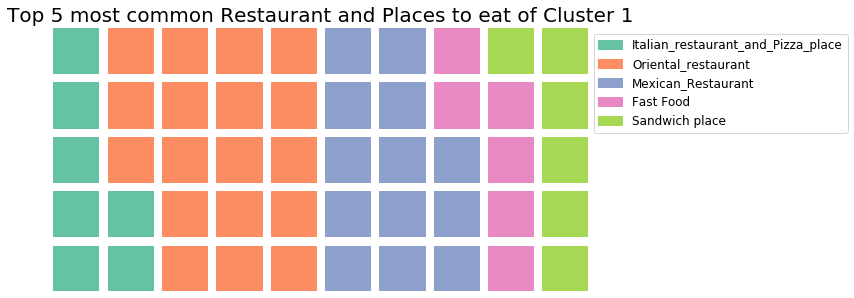

In [91]:
plt.figure(
    FigureClass=Waffle,
    rows=5,
    columns=10,
    figsize=(11,5),
    values={'Italian_restaurant_and_Pizza_place':16, 'Oriental_restaurant':39, 'Mexican_Restaurant':29, 'Fast Food':12, 'Sandwich place':12},
    title={'label': 'Top 5 most common Restaurant and Places to eat of Cluster 1', 'fontdict': {'fontsize': 20}},
    legend={'loc': 'upper left', 'bbox_to_anchor': (1, 1), 'fontsize': 12},
    plot_anchor='C')
plt.show

**Most commom Restaurants and Places to eat in Cluster 2**   
<li>Cluster 2: Despite it is a small cluster,  yet there is a balanced tendency for Mediterranean food (Falafel), French restaurant, Food truck, and Filipino restaurant.</li> 

In [92]:
# processed by hand
Cluster2_most_commom_venues_Restaurant_and_Places_in_SFV=['Falafel Restaurant','French Restaurant','Food Truck','Filipino Restaurant']
Cluster2_most_commom_venues_Restaurant_and_Places_in_SFV

['Falafel Restaurant',
 'French Restaurant',
 'Food Truck',
 'Filipino Restaurant']

<function matplotlib.pyplot.show(*args, **kw)>

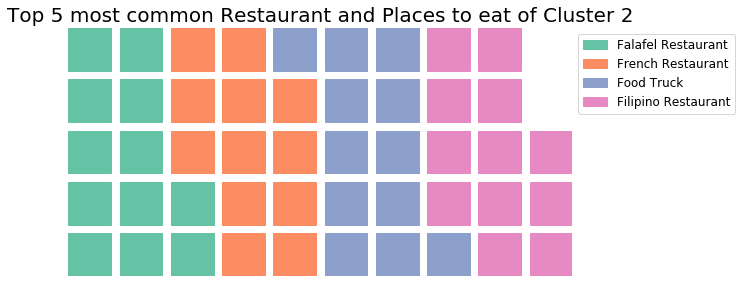

In [93]:
plt.figure(
    FigureClass=Waffle,
    rows=5,
    columns=10,
    figsize=(10,5),
    values={'Falafel Restaurant':1,'French Restaurant':1,'Food Truck':1,'Filipino Restaurant':1},
    title={'label': 'Top 5 most common Restaurant and Places to eat of Cluster 2', 'fontdict': {'fontsize': 20}},
    legend={'loc': 'upper left', 'bbox_to_anchor': (1, 1), 'fontsize': 12},
    plot_anchor='C')
plt.show

## Discussion   
*According to the two above plots, there are distinct preferences for International cuisine. Hence, a similar kind of restaurant can be competitive in the San Fernando Valley.*   
<p>However, it would be better to know both criteria: the specific neighborhood where to set the restaurant and type of restaurant.</p>

## Conclusion   
<p>The type of cuisine for the Restaurant is not defined yet. But, thanks to the clusters' finds, the client can decide his strategy, either competitive within the established market or innovative to different kinds of cuisines.</p>
<p>Knowing the most common Restaurant and Places to eat helps to refine the options because the client can make wise decisions based on customers' preferences.</p>

## Limitations   
*The structured format of the data was difficult to reach, especially for the Boroughs.*   
*For this analysis, we researched and studied the geographic and administrative organization of Los Angeles county, concluding that the organization is not by boroughs. To simplify the selection, we dealt with two categories, our Target: San Fernando Valley, and, the Not target: =! San Fernando Valley. Hence, we reduced the colossus geography of Los Angeles County into 102 neighborhoods. Surpassing this issue, finally, we calculated the clusters in the San Fernando Valley.*   

*It was not easy and took several attempts to get the unique values of the most common Restaurant and Places to eat by each cluster. Because we did not find a very efficient way to refine this search, the essential step we achieved by the append method, but in the end, we filtered by hand the small dataset.*